# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import numpy as np
import math
import matplotlib.pyplot as plt
import time
from matplotlib.ticker import MultipleLocator
from sklearn.datasets import fetch_mldata
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline


# Set the randomizer seed so results are the same each time.
np.random.seed(0)

/Users/tiffapedia/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/tiffapedia/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [2]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
mnist = fetch_mldata('MNIST original', data_home='~/datasets/mnist')
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

/Users/tiffapedia/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


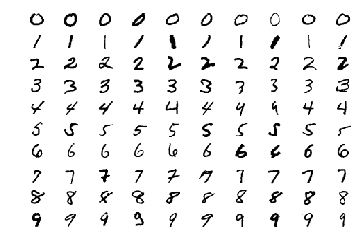

In [496]:
def gen_img(plot, arr_1d):
    # convert 1D feature vector (1*784 array) into 2D matrix (28*28 array)
    s = math.ceil(math.sqrt(mini_train_data.shape[1]))
    arr_2d = arr_1d.reshape(s,s) 
    # black background, white text
    #plt.imshow(arr_2d, cmap=plt.cm.gray)
    # white background, black text
    plot.imshow(255-arr_2d, cmap=plt.cm.gray)
    return plot

def P1(num_examples=10):

### STUDENT START ###
    unique_labels = np.unique(mini_train_labels)
    num_unique_labels = len(unique_labels)

    # define grid (width * height)
    fig = plt.figure()
    # width  = num_examples
    # height = num_unique_labels

    # assuming we have a 10*10 grid, first image's index = 1 and last image's index = 100 
    img_index = 0

    for label in unique_labels: 
        # find all indexes of the label (i.e. 0-9)
        label_indexes = np.where(Y == label)[0]
        # only iterate through the first 10 examples if num_examples = 10
        for i, label_index in enumerate(label_indexes[:num_examples]): 
            img_index += 1
            subplot = fig.add_subplot(num_unique_labels, num_examples, img_index)
            subplot.set_axis_off() 
            gen_img(subplot, X[label_index])

    fig.show()
### STUDENT END ###

# also passed in the function globally: 
# X, Y
P1(10)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

* TP (true positive): actual yes, predicted yes
* TN (true negative): actual no, predicted no
* FP (false positive): actual no, predicted yes [Type 1 error]
* FN (false negative): actual yes, predicted no [Type 2 error]

A good analogy for understanding the difference between precision and recall is: fishing net

* Precision (false negative is less of a concern)
  * How discerning is your net? Of all the stuff caught in the net, what % of them are fish?
  * (# fish)/(# fish + # non-fish)

* Recall (false positive is less of a concern)
  * How big is your net? Of all the fish in the ocean, what % did you catch?
  * (# of fish in net)/(# of fish in ocean)

In [79]:
# Precision or positive predictive value (PPV)
# how close are the measurements to each other
# ratio of correctly predicted to the total predicted positives
def precision(tp, fp):
    return (tp)/(tp + fp)

# Negative predictive value (NPV)
# ratio of correctly predicted to the total predicted negatives
def npv(tn, fn):
    return (tn)/(tn + fn)

# Sensitivity, hit rate, recall, or true positive rate (TPR)
# proportion of positives that are correctly identified
def recall(tp, fn):
    return (tp)/(tp + fn)

# Fall out or false positive rate (FPR)
# proportion of negatives that are not correctly identified
def fpr(fp, tn):
    return (fp)/(fp + tn)

# Specificity or true negative rate (TNR)
# proportion of negatives that are correctly identified
def specificity(tn, fp):
    return (tn)/(tn + fp)

# False negative rate
# proportion of negatives that are not correctly identified
def fnr(fn, tp):
    return (fn)/(fn + tp)

# Accuracy
# how close is the measurement to the true value
# better measurement of accuracy if FP and FN have **similar cost**
# not used in real setting
def accuracy(tp, tn, fp, fn):
    return (tp + tn)/(tp + fp + tn + fn)

# F1-score
# weighted average of precision and recall 
# better measurement of accuracy if FP and FN have **different cost**
# not used in real setting
# 1 == perfect precision and recall
# 0 == terrible precision and recall
def f1_scores(tp, fp, fn):
    p = precision(tp, fp)
    r = recall (tp, fn)
    return 2 * ((p * r)/(p + r))

# False discovery rate
# proportion of false positives above threshold
def fdr(fp, tp):
    return (fp)/(fp + tp)

<img src="https://i.stack.imgur.com/AuTKP.png">

In [82]:
def manual_f1(y_actual, y_hat):
    cm = confusion_matrix(y_actual, y_hat)
    fp = cm.sum(axis=0) - np.diag(cm)
    fn = cm.sum(axis=1) - np.diag(cm)
    tp = np.diag(cm)
    tn = cm.sum() - (fp + fn + tp)
    return f1_scores(tp, fp, fn)
    
def P2(k_values):

### STUDENT START ###
    accuracies = []

    for k in k_values:

        if k > len(mini_train_data):
            raise ValueError('cannot have more neighbors than training samples')

        # train KNN with current k using mini training set
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(mini_train_data, mini_train_labels)

        # make prediction on dev set
        dev_predicted_labels = model.predict(dev_data)

        # report accuracy on dev set
        # method #1: manually
        #accuracy = np.mean(dev_predicted_labels == dev_labels)
        # method #2: using KNeighborsClassifier's score function
        accuracy = model.score(dev_data, dev_labels)

        accuracies.append(accuracy)
        print("k = %d" % k)
        print("accuracy = %.2f%%" % (accuracy * 100))

        # we will later learn that k = 1 achieves highest accuracy on dev data
        if k == 1:
            # classification report: report precision, recall, f1 for each label
            print(classification_report(dev_labels, dev_predicted_labels, labels=range(0, 10)))
            # which is the most difficult digit?
            # method #1: manually
            f1_scores = manual_f1(dev_labels, dev_predicted_labels)
            # method #2: using sklearn.metrics's f1_score function
            #from sklearn.metrics import f1_score
            #f1_scores = f1_score(dev_labels, dev_predicted_labels, average=None)
            min_index = int(np.argmin(f1_scores))
            print("The most difficult digit based on the F1-score is %d" % (np.unique(Y)[min_index]))

    max_index = int(np.argmax(accuracies))
    print("k = %d achieved highest accuracy of %.2f%% on dev data" % (k_values[max_index], accuracies[max_index] * 100))
    min_index = int(np.argmin(accuracies))
    print("k = %d achieved lowest accuracy of %.2f%% on dev data" % (k_values[min_index], accuracies[min_index] * 100))
    
### STUDENT END ###

k_values = [1, 3, 5, 7, 9]
# also passed in the function globally: 
# mini_train_data, mini_train_labels, dev_data, dev_labels
P2(k_values)


k = 1
accuracy = 88.80%
             precision    recall  f1-score   support

          0       0.91      0.98      0.94        99
          1       0.89      1.00      0.94       105
          2       0.99      0.79      0.88       102
          3       0.77      0.87      0.82        86
          4       0.89      0.82      0.85       104
          5       0.93      0.84      0.88        91
          6       0.94      0.96      0.95        98
          7       0.89      0.92      0.90       113
          8       0.94      0.88      0.91        96
          9       0.78      0.82      0.80       106

avg / total       0.89      0.89      0.89      1000

The most difficult digit based on the F1-score is 9
k = 3
accuracy = 87.80%
k = 5
accuracy = 86.90%
k = 7
accuracy = 86.50%
k = 9
accuracy = 86.30%
k = 1 achieved highest accuracy of 88.80% on dev data
k = 9 achieved lowest accuracy of 86.30% on dev data


ANSWER:

The number 9 appears to be the most difficult digit to predict with precision of 0.78, recall of 0.82, and F1-score of 0.80.

Also note, as k becomes larger, the decision boundary becomes smoother and therefore less accurate. In general, larger k models are less complex compared to smaller k models. Complex model runs the risk to be sensitive to noise and can lead to overfitting.

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [100]:
def P3(train_sizes, accuracies):

### STUDENT START ###
    def accuracy_knn(k, train_size):
        # set model as KNN with k = 1
        model = KNeighborsClassifier(n_neighbors=k)

        # start timer
        start_time = time.time()

        # train KNN with k = 1 using training set
        model.fit(train_data[:train_size], train_labels[:train_size])

        # make predictions on dev set
        dev_predicted_labels = model.predict(dev_data)

        # end timer
        end_time = time.time()

        # get accuracy on dev set
        accuracy = model.score(dev_data, dev_labels)

        # report accuracy and amount of time needed for prediction with each training size of k = 1
        return {'k': k,
                'train size': train_size,  
                'accuracy': accuracy,
                'time': round(end_time-start_time, 2)}

    header = ['k', 'train size', 'accuracy', 'time (sec)']
    row_format = '{:>15}' * (len(header) + 1)
    print(row_format.format('', *header))
    for train_size in train_sizes:
        outcome = accuracy_knn(1, train_size)      
        accuracies.append(outcome['accuracy'])
        print(row_format.format('', *outcome.values()))
    return accuracies

### STUDENT END ###

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = []
# also passed in the function globally: 
# train_data, train_labels, dev_data, dev_labels
P3(train_sizes, accuracies)

                             k     train size       accuracy     time (sec)
                             1            100           0.72           0.08
                             1            200          0.786           0.16
                             1            400          0.841           0.33
                             1            800          0.884           0.68
                             1           1600          0.902           1.36
                             1           3200          0.926           2.73
                             1           6400          0.937            5.8
                             1          12800          0.959          12.68
                             1          25000           0.97          27.86


[0.72, 0.786, 0.841, 0.884, 0.902, 0.926, 0.937, 0.959, 0.97]

(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

For training size n = 60000,
OLS predict an accuracy of 124.31%
OLS with logit transformation predict an accuracy of 99.88%


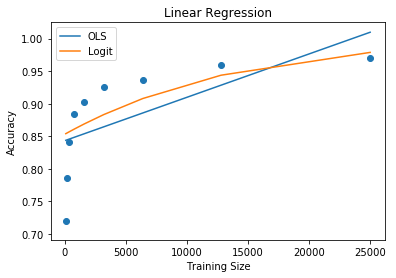

In [134]:
def P4():

### STUDENT START ###
    n = 60000
    
    def logit_transform(y):
        return np.log(y / (1-y))

    def un_logit_transform(y_hat):
        return 1 / (1 + np.exp(-y_hat))

    # convert shape of train_sizes and accuracies from (1, 9) to (9, 1)
    x = np.reshape(train_sizes, (len(train_sizes), 1))
    y = np.reshape(accuracies, (len(accuracies), 1))

    # train linear regression using the given dataset
    ols_model = LinearRegression()
    ols_model.fit(x, y)

    # train linear regression with logit transformation using the given dataset
    logit_model = LinearRegression()
    logit_model.fit(x, logit_transform(y))

    # plot linear regression and its logit transformation
    plt.title('Linear Regression')
    plt.xlabel('Training Size')
    plt.ylabel('Accuracy')
    plt.scatter(x, y)
    plt.plot(x, ols_model.predict(x), label='OLS')
    plt.plot(x, un_logit_transform(logit_model.predict(x)), label='Logit')
    plt.legend()

    # predict for training size n = 60000
    ols_y_hat = ols_model.predict(n)
    logit_y_hat = un_logit_transform(logit_model.predict(n))
    print('For training size n = {},\nOLS predict an accuracy of {}%\nOLS with logit transformation predict an accuracy of {}%'
          .format(n, round(float(ols_y_hat) * 100, 2), round(float(logit_y_hat) * 100, 2)))

### STUDENT END ###

# also passed in the function globally: 
# train_sizes, accuracies (computed in P3)
P4()

ANSWER:  
OLS regression predicts the accuracy of training size n = 60,000 to be 124.31%, which is invalid because it exceeds 100%. The logit transformation guarantees that the predicted accuracy will be between 0 to 1. For that reason, the OLS regression with logit transformation predicts the accuracy of training size n = 60,000 to be 99.88%. 

Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

Confusion matrix for k = 1:

[[ 97   0   0   0   0   0   2   0   0   0]
 [  0 105   0   0   0   0   0   0   0   0]
 [  4   4  81   4   0   0   0   4   3   2]
 [  1   0   0  75   0   3   0   3   1   3]
 [  0   2   0   0  85   0   3   0   0  14]
 [  2   0   0   9   0  76   0   1   1   2]
 [  1   1   1   0   1   0  94   0   0   0]
 [  1   4   0   1   1   0   0 104   0   2]
 [  0   2   0   5   0   2   1   0  84   2]
 [  1   0   0   3   9   1   0   5   0  87]]

The most confused pair of digits is predicting a 9 when it's actually a 4.


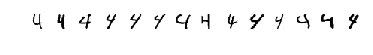

In [60]:
def plot_example(data, label_indexes, num_examples=10):
    # this will plot a grid of 1 x num_examples
    # x = data, y = label
    fig = plt.figure()
    for img_index, label_index in enumerate(label_indexes[:num_examples]):
        img_index += 1 # img_index cannot start at 0
        subplot = fig.add_subplot(1, num_examples, img_index)
        subplot.set_axis_off()
        gen_img(subplot, data[label_index])

def P5():

### STUDENT START ###
    k = 1

    # train KNN with current k using mini training set
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(mini_train_data, mini_train_labels)

    # make prediction on dev set
    dev_predicted_labels = model.predict(dev_data)

    # print the confusion matrix for the dev data
    cm = confusion_matrix(dev_labels, dev_predicted_labels)
    print('Confusion matrix for k = {}:\n\n{}\n'.format(k, cm))

    # identify the most confused pair of digits
    # 1. create a mask of the diagonal, the true positives (tp)
    mask = np.ones(cm.shape, dtype=bool)
    np.fill_diagonal(mask, False)
    # 2. find index of maximum value in confusion matrix other than tp
    actual_cm_index, predicted_cm_index = np.where(cm == cm[mask].max())
    actual_label = actual_cm_index[0]
    predicted_label = predicted_cm_index[0]
    print('The most confused pair of digits is predicting a {} when it\'s actually a {}.'
          .format(predicted_label, actual_label))

    # show example of the most confused pair of digits
    # 1. determine shared index of most confused actual label and most confused predicted label
    actual_label_indexes = np.where(dev_labels == actual_label)
    predicted_label_indexes = np.where(dev_predicted_labels == predicted_label)
    most_confused_label_indexes = np.intersect1d(actual_label_indexes, predicted_label_indexes)
    # 2. plot the example
    plot_example(dev_data, most_confused_label_indexes, len(most_confused_label_indexes))
### STUDENT END ###

# also passed in the function globally: 
# train_data, train_labels, dev_data, dev_labels
P5()

If instead we would like to find the most confused false positive or the most confused false negative from the confusion matrix with 1-NN fit, we can do it as follows:   

Confusion matrix for k = 1:

[[ 97   0   0   0   0   0   2   0   0   0]
 [  0 105   0   0   0   0   0   0   0   0]
 [  4   4  81   4   0   0   0   4   3   2]
 [  1   0   0  75   0   3   0   3   1   3]
 [  0   2   0   0  85   0   3   0   0  14]
 [  2   0   0   9   0  76   0   1   1   2]
 [  1   1   1   0   1   0  94   0   0   0]
 [  1   4   0   1   1   0   0 104   0   2]
 [  0   2   0   5   0   2   1   0  84   2]
 [  1   0   0   3   9   1   0   5   0  87]]

The digits with the most false positive to the least false positive are: [9 3 7 1 4 0 6 5 8 2]
The digit with the most false positive is 9.
Predicting a 9 when it's actually a 4 is the most common mistake (14 mistakes in total).
Examples are shown below:


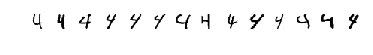

In [32]:
def sort_asc_value_by_index(array):
    # get the index of biggest elements in decreasing order
    return np.argsort(array)[::-1][:len(array)]

def show_most_false_positive_digit():
    k = 1

    # train KNN with current k using mini training set
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(mini_train_data, mini_train_labels)

    # make prediction on dev set
    dev_predicted_labels = model.predict(dev_data)

    # print the confusion matrix for the dev data
    cm = confusion_matrix(dev_labels, dev_predicted_labels)
    print('Confusion matrix for k = {}:\n\n{}\n'.format(k, cm))

    # identify the false positive (fp) digits in ascending order
    # fp: predict yes, actual no (type 1 error)
    fp = cm.sum(axis=0) - np.diag(cm)
    fp_asc_labels = sort_asc_value_by_index(fp)
    print('The digits with the most false positive to the least false positive are: {}'
         .format(fp_asc_labels))

    # identify the most fp digit with the most common actual digit mistake
    predicted_fp_digit = fp_asc_labels[0]
    actual_fp_digits_count = cm[:,predicted_fp_digit]
    actual_fp_digits_count[predicted_fp_digit] = 0 # need to do this for tp
    actual_fp_digits = sort_asc_value_by_index(actual_fp_digits_count)
    actual_fp_digit = actual_fp_digits[0]
    print('The digit with the most false positive is {}.'
          .format(predicted_fp_digit))
    print('Predicting a {} when it\'s actually a {} is the most common mistake ({} mistakes in total).'
          .format(predicted_fp_digit, actual_fp_digit, max(actual_fp_digits_count)))

    # show example of the most confused pair of digits
    actual_label_indexes = np.where(dev_labels == actual_fp_digit)
    predicted_label_indexes = np.where(dev_predicted_labels == predicted_fp_digit)
    most_confused_label_indexes = np.intersect1d(actual_label_indexes, predicted_label_indexes)
    print('Examples are shown below:')
    plot_example(dev_data, most_confused_label_indexes, len(most_confused_label_indexes))    
    
show_most_false_positive_digit()

Confusion matrix for k = 1:

[[ 97   0   0   0   0   0   2   0   0   0]
 [  0 105   0   0   0   0   0   0   0   0]
 [  4   4  81   4   0   0   0   4   3   2]
 [  1   0   0  75   0   3   0   3   1   3]
 [  0   2   0   0  85   0   3   0   0  14]
 [  2   0   0   9   0  76   0   1   1   2]
 [  1   1   1   0   1   0  94   0   0   0]
 [  1   4   0   1   1   0   0 104   0   2]
 [  0   2   0   5   0   2   1   0  84   2]
 [  1   0   0   3   9   1   0   5   0  87]]

The digits with the most false negative to the least false negative are: [2 9 4 5 8 3 7 6 0 1]
The digit with the most false negative is 2.
Digit 2 is most commonly predicted as 7 (4 mistakes in total).
Examples are shown below:


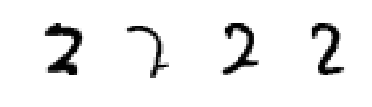

In [33]:
def show_most_false_negative_digit():
    k = 1

    # train KNN with current k using mini training set
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(mini_train_data, mini_train_labels)

    # make prediction on dev set
    dev_predicted_labels = model.predict(dev_data)

    # print the confusion matrix for the dev data
    cm = confusion_matrix(dev_labels, dev_predicted_labels)
    print('Confusion matrix for k = {}:\n\n{}\n'.format(k, cm))

    # identify the false negative (fn) digits in ascending order
    # fn: predict no, actual yes (type 2 error)
    fn = cm.sum(axis=1) - np.diag(cm)
    fn_asc_labels = sort_asc_value_by_index(fn)
    print('The digits with the most false negative to the least false negative are: {}'
         .format(fn_asc_labels))

    # identify the most fn digit with the most common predicted digit mistake
    actual_fn_digit = fn_asc_labels[0]
    predicted_fn_digits_count = cm[actual_fn_digit,:]
    predicted_fn_digits_count[actual_fn_digit] = 0 # need to do this for tp
    predicted_fn_digits = sort_asc_value_by_index(predicted_fn_digits_count)
    predicted_fn_digit = predicted_fn_digits[0]
    print('The digit with the most false negative is {}.'
          .format(actual_fn_digit))
    print('Digit {} is most commonly predicted as {} ({} mistakes in total).'
          .format(actual_fn_digit, predicted_fn_digit, max(predicted_fn_digits_count)))

    # show example of the most confused pair of digits
    actual_label_indexes = np.where(dev_labels == actual_fn_digit)
    predicted_label_indexes = np.where(dev_predicted_labels == predicted_fn_digit)
    most_confused_label_indexes = np.intersect1d(actual_label_indexes, predicted_label_indexes)
    print('Examples are shown below:')
    plot_example(dev_data, most_confused_label_indexes, len(most_confused_label_indexes))
    
show_most_false_negative_digit()

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

<img src="https://preview.ibb.co/dkc7DT/Screen_Shot_2018_06_08_at_8_04_36_PM.png">

Reference: https://www.youtube.com/watch?v=C_zFhWdM4ic


1. preprocess the training data but not the dev data:
accuracy: 90.6%
2. preprocess the dev data but not the training data
accuracy: 87.5%
3. preprocess both training and dev data
accuracy: 90.0%
Examples of mini_train_data and dev_data after gaussian blur:


/Users/tiffapedia/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


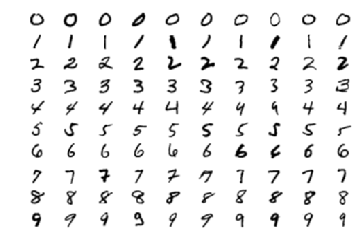

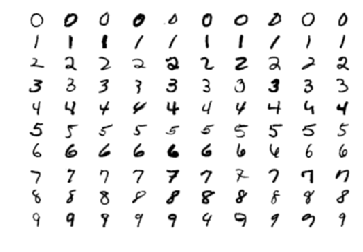

In [510]:
def P6():
    
### STUDENT START ###
    def gaussian_blur(arr_1d_img):
        # convert 1D feature vector (1*784 array) into 2D matrix (28*28 array)
        s = math.ceil(math.sqrt(mini_train_data.shape[1]))
        img = arr_1d_img.reshape(s,s)

        # define kernel
        kernel = np.array([[1, 2, 1],
                           [2, 4, 2],
                           [1, 2, 1]])
        kernel = kernel/np.sum(kernel)
        # probabilities should sum to 1
        #print(sum(sum(kernel)))

        # define convolution output
        output = np.zeros_like(img)

        # add zero padding to the input image
        img_padded = np.zeros((img.shape[0] + 2, img.shape[1] + 2))
        img_padded[1:-1, 1:-1] = img

        # loop every pixel in the image
        for x in range(img.shape[1]): # over column
            for y in range(img.shape[0]): # over row
                # matrix multiplication between kernel and padded image
                output[y, x] = (kernel * img_padded[y:y+3, x:x+3]).sum()
        return output

    def gaussian_blur_data(data):
        output = np.zeros_like(data)
        for i, img in enumerate(data):
            output[i] = gaussian_blur(img).flatten()
        return output
    
    def show_examples(x, y, num_examples=10):
        unique_labels = np.unique(y)
        num_unique_labels = len(unique_labels)

        # define grid (width * height)
        fig = plt.figure()
        # width  = num_examples
        # height = num_unique_labels

        # assuming we have a 10*10 grid, first image's index = 1 and last image's index = 100 
        img_index = 0

        for label in unique_labels: 
            # find all indexes of the label (i.e. 0-9)
            label_indexes = np.where(y == label)[0]
            # only iterate through the first 10 examples if num_examples = 10
            for i, label_index in enumerate(label_indexes[:num_examples]): 
                img_index += 1
                subplot = fig.add_subplot(num_unique_labels, num_examples, img_index)
                subplot.set_axis_off() 
                gen_img(subplot, x[label_index])
                
        fig.show()
        return

    # train KNN with current k = 1
    k = 1
    model = KNeighborsClassifier(n_neighbors=k)

    gb_mini_train_data = gaussian_blur_data(mini_train_data)
    gb_dev_data = gaussian_blur_data(dev_data)

    print('1. preprocess the training data but not the dev data:')
    model.fit(gb_mini_train_data, mini_train_labels)
    dev_predicted_labels = model.predict(dev_data)
    accuracy = model.score(dev_data, dev_labels)
    print('accuracy: {}%'.format(round(accuracy * 100, 2)))
    
    print('2. preprocess the dev data but not the training data')
    model.fit(mini_train_data, mini_train_labels)
    dev_predicted_labels = model.predict(gb_dev_data)
    accuracy = model.score(gb_dev_data, dev_labels)
    print('accuracy: {}%'.format(round(accuracy * 100, 2)))

    print('3. preprocess both training and dev data')
    model.fit(gb_mini_train_data, mini_train_labels)
    dev_predicted_labels = model.predict(gb_dev_data)
    accuracy = model.score(gb_dev_data, dev_labels)
    print('accuracy: {}%'.format(round(accuracy * 100, 2)))
    
    print('Examples of mini_train_data and dev_data after gaussian blur:')
    show_examples(gb_mini_train_data, mini_train_labels)
    show_examples(gb_dev_data, dev_labels)
    
### STUDENT END ###

P6()

ANSWER:

Gaussian blur improves the accuracy of the model to predict the digit. If the dev dataset was blurred but the training dataset was not, the accuracy drops. If it was the other way around, the accuracy improves. This intuition makes sense because blurring an image during training allows more flexibility in mapping unseen digit with slightly different shape onto the training dataset. 

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

In [120]:
def P7():
 
### STUDENT START ###
    def accuracy_bernoulli(binarize):
        binarize = round(binarize, 2)
        
        # using mini training set, train a Naive Bayes classifier with binarize as a threshold
        model = BernoulliNB(binarize=binarize)
        model.fit(mini_train_data, mini_train_labels)

        # make prediction on dev set
        dev_predicted_labels = model.predict(dev_data)

        # report accuracy on dev set
        accuracy = model.score(dev_data, dev_labels)

        # cross validate the accuracy score 
        #print(classification_report(dev_labels, dev_predicted_labels, labels=range(0, 10)))

        return {'model': 'BernoulliNB',
                'threshold': binarize,  
                'accuracy': accuracy}
    
    def accuracy_multinomial(lower_range, upper_range):    
        lower_range = round(lower_range, 2)
        upper_range = round(upper_range, 2)
        
        # modify a copy of the mini training set so that we can
        mtd = np.copy(mini_train_data)
        # identify white
        mtd[mtd <= lower_range] = 0
        # identify grey
        mtd[np.logical_and(lower_range < mtd, mtd < upper_range)] = 1
        # identify black
        mtd[mtd >= upper_range] = 2

        # train a Naive Bayes classifier with the multinomial converted mini training set
        model = MultinomialNB()
        model.fit(mtd, mini_train_labels)

        # make prediction on dev set
        dev_predicted_labels = model.predict(dev_data)

        # report accuracy on dev set
        accuracy = model.score(dev_data, dev_labels)    

        return {'model': 'MultinomialNB',
                'threshold': '({}, {})'.format(lower_range, upper_range),  
                'accuracy': accuracy}
    
    # define the thresholds
    binary_thresholds = np.arange(0, 1, 0.1)
    multinomial_lower_ranges = np.arange(0.1, 0.6, 0.1)
    multinomial_upper_ranges = np.arange(0.9, 0.4, -0.1)

    # print header
    header = ['model', 'threshold', 'accuracy']
    row_format = '{:>15}' * (len(header) + 1)
    print(row_format.format('', *header))
    # print bernoulli's accuracies 
    for threshold in binary_thresholds:
        outcome = accuracy_bernoulli(threshold)      
        print(row_format.format('', *outcome.values()))
    # print multinomial's accuracies
    for lower_range, upper_range in zip(multinomial_lower_ranges, multinomial_upper_ranges):
        outcome = accuracy_multinomial(lower_range, upper_range)
        print(row_format.format('', *outcome.values()))
### STUDENT END ###
                         
# also passed in the function globally: 
# mini_train_data, mini_train_labels, dev_data, dev_labels
P7()

                         model      threshold       accuracy
                   BernoulliNB            0.0          0.815
                   BernoulliNB            0.1          0.813
                   BernoulliNB            0.2          0.821
                   BernoulliNB            0.3          0.818
                   BernoulliNB            0.4          0.818
                   BernoulliNB            0.5          0.815
                   BernoulliNB            0.6          0.813
                   BernoulliNB            0.7          0.802
                   BernoulliNB            0.8          0.797
                   BernoulliNB            0.9          0.767
                 MultinomialNB     (0.1, 0.9)          0.795
                 MultinomialNB     (0.2, 0.8)          0.798
                 MultinomialNB     (0.3, 0.7)          0.797
                 MultinomialNB     (0.4, 0.6)          0.797
                 MultinomialNB     (0.5, 0.5)          0.795


ANSWER: 

Binary-valued features perform better at lower thresholds. At upper thresholds, it becomes more difficult to distinguish what we define as "black" versus "white" pixels. **Adding grey in the multi-class version does not improve the results.** This interpretation seems reasonable because we do not identify a digit based on the different pressure people write the digit but by the shape of the digit. For this reason, mapping the pixel values to black or white makes a better classifier for this use case. 


(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

Reference: http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html

In [155]:
def P8(alphas):

### STUDENT START ###
    # specify what model to use, in this case Bernoulli
    model = BernoulliNB()
    
    # Bernoulli NB model has four parameters:
    # 1. alpha: additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing), default = 1.0
    # 2. binarize: threshold for binarizing of sample features (None for data that's already binary), default = 0.0
    # 3. fit_prior: whether to learn class prior probabilities (false for uniform prior to be used), default = True
    # 4. class_prior: prior probabilities of classes, default = None
    
    # specify parameter candidate to find the best param for model
    # we only care about finding the best alpha and binarize 
    # and leave fit_prior (= 0.0) and class_prior (= True) to default
    param_candidate_1 = alphas
    param_candidate_1.update({'binarize': np.arange(0, 1, 0.1)})
    
    # if more than one parameter candidates are given:
    #parameter_candidates = [parameter_candidate_1, parameter_candidate_2]
    
    # perform cross validation to find the best parameter for the model
    cv = GridSearchCV(model, param_candidate_1)
    cv.fit(mini_train_data, mini_train_labels)
    return cv
### STUDENT END ###

# also passed in the function globally: 
# mini_train_data, mini_train_labels
alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = P8(alphas)
   
nb.grid_scores_

/Users/tiffapedia/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:801: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/Users/tiffapedia/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:820: RuntimeWarning: divide by zero encountered in log
  neg_prob = np.log(1 - np.exp(self.feature_log_prob_))
/Users/tiffapedia/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:801: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/Users/tiffapedia/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:820: RuntimeWarning: divide by zero encountered in log
  neg_prob = np.log(1 - np.exp(self.feature_log_prob_))
/Users/tiffapedia/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:801: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/Users/tiffapedia/anaconda3/lib/python3.6/site-packages/sklearn/naiv

[mean: 0.09200, std: 0.00080, params: {'alpha': 0.0, 'binarize': 0.0},
 mean: 0.09200, std: 0.00080, params: {'alpha': 0.0, 'binarize': 0.1},
 mean: 0.09200, std: 0.00080, params: {'alpha': 0.0, 'binarize': 0.2},
 mean: 0.09200, std: 0.00080, params: {'alpha': 0.0, 'binarize': 0.30000000000000004},
 mean: 0.09200, std: 0.00080, params: {'alpha': 0.0, 'binarize': 0.4},
 mean: 0.09200, std: 0.00080, params: {'alpha': 0.0, 'binarize': 0.5},
 mean: 0.09200, std: 0.00080, params: {'alpha': 0.0, 'binarize': 0.6000000000000001},
 mean: 0.09200, std: 0.00080, params: {'alpha': 0.0, 'binarize': 0.7000000000000001},
 mean: 0.09200, std: 0.00080, params: {'alpha': 0.0, 'binarize': 0.8},
 mean: 0.09200, std: 0.00080, params: {'alpha': 0.0, 'binarize': 0.9},
 mean: 0.82000, std: 0.02208, params: {'alpha': 0.0001, 'binarize': 0.0},
 mean: 0.81700, std: 0.02450, params: {'alpha': 0.0001, 'binarize': 0.1},
 mean: 0.82000, std: 0.02208, params: {'alpha': 0.0001, 'binarize': 0.2},
 mean: 0.82300, std: 0

In [156]:
# print the highest mean, aka the best score
print(nb.best_score_)

0.829


In [159]:
# print the best parameters used for the Bernoulli NB model
print(nb.best_params_)

{'alpha': 0.01, 'binarize': 0.30000000000000004}


In [160]:
# print how to define the model with the best parameters
print(nb.best_estimator_)

BernoulliNB(alpha=0.01, binarize=0.30000000000000004, class_prior=None,
      fit_prior=True)


ANSWER:

The best value is for alpha to be 0.01 and binarize to be 0.3 because these params maximize the model accuracy to 82.9%. The accuracy when alpha = 0 regardless of the binarize value is 9.2%. It is not surprising that alpha = 0 will result in the model accurately predicting digit approximately close to 10% because it is no different than randomly guessing a digit with no other information provided, which is 1 out of 10 or approximately 10%. The reason being is that without smoothing, the model will not be able to identify the digit because the digit's pixels in the dev data will not identically match the digit's pixels in the training data. For that reason, the model will miscategorize the digit, and it becomes similar to random guessing.

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

Gaussian model without normalization:
accuracy: 62.1%


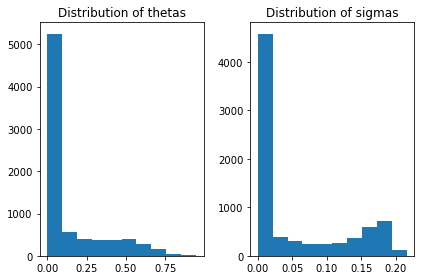

probabilities per digit: [0.092 0.106 0.106 0.112 0.091 0.088 0.101 0.101 0.092 0.111]

Gaussian model with normalization:
accuracy: 80.2%


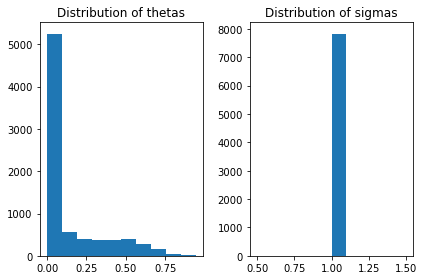

In [410]:
from scipy.stats import norm
def P9():

### STUDENT END ###
    def plot_thetas_and_sigmas(model):       
        plt.subplot(1, 2, 1)
        plt.hist(model.theta_.flatten())
        plt.title('Distribution of thetas')
        plt.subplot(1, 2, 2)
        plt.hist(model.sigma_.flatten())
        plt.title('Distribution of sigmas')
        plt.tight_layout() # prevent plots overlap
        plt.show()
        
    # Gaussian model without normalization: 
    print('Gaussian model without normalization:')
    # train the Gaussian model with mini_train_data
    prior_model = GaussianNB()
    prior_model.fit(mini_train_data, mini_train_labels)
    # report accuracy on dev set
    accuracy = prior_model.score(dev_data, dev_labels)
    print('accuracy: {}%'.format(round(accuracy * 100, 2)))
    # plot the model's thetas and sigmas
    # theta: mean of each feature per class
    # sigma: variance of each feature per class
    plot_thetas_and_sigmas(prior_model)
    print('probabilities per digit: {}\n'.format(prior_model.class_prior_))
    
    # Gaussian model with normalization
    print('Gaussian model with normalization:')
    # train the Gaussian model with posterior probabilities and mini_train_data
    model = GaussianNB()
    model.fit(mini_train_data, mini_train_labels)    
    # tune the hyperparameters theta (mean) and sigmas (variance)
    # in other words, change the mean and variance to improve accuracy
    # in our case, we just change the variance
    model.sigma_ = np.ones_like(model.sigma_)  
    # report accuracy on dev set
    accuracy = model.score(dev_data, dev_labels)
    print('accuracy: {}%'.format(round(accuracy * 100, 2)))
    # plot the model's thetas and sigmas
    plot_thetas_and_sigmas(model)
    
    return model

### STUDENT END ###

# also passed in the function globally: 
# mini_train_data, mini_train_labels, dev_data, dev_labels
gnb = P9()

ANSWER:

Having sigma (variance) close to zero in the Gaussian model is similar to having alpha being close to zero in the Bernoulli model. Adding any noise, in particular smoothing, increases the variability and thereby increases the accuracy. We can do this by simply setting sigma equal to 1. Once we did that, we can see that the accuracy improves from 62.1% to 80.2%, similar to the Bernoulli model. 

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

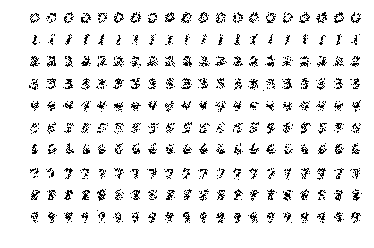

In [435]:
def P10(num_examples):

### STUDENT START ###

    # specify Bernoulli model with the best estimated parameters found in P8
    model = BernoulliNB(alpha=0.01, binarize=0.3)
    # train the model with mini_train_data
    model.fit(mini_train_data, mini_train_labels)
    
    unique_labels = np.unique(mini_train_labels)
    num_unique_labels = len(unique_labels)
    
    # size of 1D feature vector (1 * 784) for an image: 784
    s_1d = mini_train_data.shape[1]
    
    # define grid (width * height)
    fig = plt.figure()
    # width = num_examples
    # height = num_unique_labels
    
    # assuming we have a 20*20 grid, first image's index = 1 and last image's index = 200 
    img_index = 0
    
    for label in unique_labels:
        label = int(label)
        # find all indexes of the label (i.e. 0-9)
        label_indexes = np.where(mini_train_labels == label)[0]
        # only iterate through the first 20 examples if num_examples = 20
        for i, label_index in enumerate(label_indexes[:num_examples]):
            img_index += 1
            subplot = fig.add_subplot(num_unique_labels, num_examples, img_index)
            subplot.set_axis_off()
            gen_img(subplot, np.random.rand(s_1d) < np.exp(model.feature_log_prob_[label]))            
            
### STUDENT END ###

# also passed in the function globally: 
# mini_train_data, mini_train_labels, dev_data, dev_labels
P10(20)

ANSWER:

Since each pixel is evaulated independently, the resulting digits that are generated are more grainy compared to the original ones.

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

References: http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html

In [454]:
def P11(buckets, correct, total):
    
### STUDENT START ###
    # specify Bernoulli model with the best estimated parameters found in P8
    model = BernoulliNB(alpha=0.01, binarize=0.3)
   
    # train the model with mini_train_data
    model.fit(mini_train_data, mini_train_labels)
    
    # make prediction on dev set
    dev_predicted_labels = model.predict(dev_data)
    
    # get the list of predicted probabilities for each image
    # [prob_0, prob_1, ..., prob_9]
    # 1. using BernoulliNB's predict_log_proba function 
    # dev_predicted_prob = np.exp(model.predict_log_proba(dev_data))
    # 2. using BernoulliNB's predict_proba function
    dev_predicted_prob = model.predict_proba(dev_data)
    
    # get the posterior probability
    # meaning highest prob from the list of predicted probabilties
    # as the most likely label for the image
    dev_posterior_prob = np.max(dev_predicted_prob, axis=1)
    
    # count the number of posterior probability are within the bucket and store it in total
    # count the number of posterior probability within the bucket are correct and store it in correct
    for p in range(len(dev_posterior_prob)):
        for b in range(len(buckets)):
            # check that each posterior probability is within the bucket
            if dev_posterior_prob[p] <= buckets[b]:
                # count the number of posterior probability within the bucket
                total[b] += 1
                # count the number of posterior probability being correct
                if dev_predicted_labels[p] == dev_labels[p]:
                    correct[b] += 1
                
### STUDENT END ###

# also passed in the function globally: 
# mini_train_data, mini_train_labels, dev_data, dev_labels

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

P11(buckets, correct, total)

for i in range(len(buckets)):
    accuracy = 0.0
    if (total[i] > 0): accuracy = correct[i] / total[i]
    print('p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy))

(1000,) (1000,)
p(pred) <= 0.5000000000000    total =   2    accuracy = 0.500
p(pred) <= 0.9000000000000    total =  43    accuracy = 0.349
p(pred) <= 0.9990000000000    total = 118    accuracy = 0.381
p(pred) <= 0.9999900000000    total = 184    accuracy = 0.484
p(pred) <= 0.9999999000000    total = 242    accuracy = 0.512
p(pred) <= 0.9999999990000    total = 304    accuracy = 0.553
p(pred) <= 0.9999999999900    total = 364    accuracy = 0.599
p(pred) <= 0.9999999999999    total = 426    accuracy = 0.634
p(pred) <= 1.0000000000000    total = 1000    accuracy = 0.822


ANSWER:

The Naive Bayes model is weakly callibrated. When the posterior probability of the predicted class is almost close to 1, the accuracy is roughly 82.2% when it should have been closed to almost 100%. 

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [467]:
def P12():

### STUDENT START ###
    def sum_pixels(data):
        # sum pixel values in each row and each column

        # convert 1D feature vector (1*784 array) into 2D matrix (28*28 array)
        s = math.ceil(math.sqrt(mini_train_data.shape[1]))
        
        # create a new feature vector with the dimension: 
        # num_imgs * (len(sum_rows) + len(sum_cols))
        # 100 * (28 + 28)
        # note: sum_rows and sum_cols have shape 1*28 after summing up
        num_imgs = data.shape[0]
        new_features = np.zeros((num_imgs, s+s)) 
        for pixel_index, img in enumerate(data):
            sum_rows = np.sum(img.reshape(s, s), axis=1)
            sum_cols = np.sum(img.reshape(s, s), axis=1)
            new_features[pixel_index] = np.append(sum_rows, sum_cols)
            
        # add the new feature into the data via the column
        return np.concatenate([data, new_features], axis=1)

    # before improvement:
    # specify Bernoulli model with the best estimated parameters found in P8
    model = BernoulliNB(alpha=0.01, binarize=0.3)
    # train the model with mini_train_data
    model.fit(mini_train_data, mini_train_labels)
    # report accuracy on dev set before improvement
    accuracy = model.score(dev_data, dev_labels)
    print('accuracy before improvement: {}%'.format(round(accuracy * 100, 2)))
    
    # after improvement:
    model.fit(sum_pixels(mini_train_data), mini_train_labels)
    accuracy = model.score(sum_pixels(dev_data), dev_labels)
    print('accuracy after improvement (sum pixels): {}%'.format(round(accuracy * 100, 2)))
    

### STUDENT END ###

P12()

accuracy before improvement: 82.2%
accuracy after improvement (sum pixels): 83.8%


# References
1. R: http://varianceexplained.org/r/digit-eda/ 